# Usage of the Event Detector by Barsim et al.

# Load the required packages

In [24]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import public packages
import sys
import os
from pathlib import Path
#import ipdb
from matplotlib import pyplot as plt
import glob
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from io import StringIO

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_Barsim_Sequential 

# Activate Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set all global Parameters for the BLUED Dataset

In [2]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
DATASET = "blued_events" #name of the dataset (used to load the file later with my Utility class)
CURRENT_COLUMN = "Current B" # Dataset has two phases: phase A and B. They can be treated independently. We load only Phase B.
NETWORK_FREQUENCY_BLUED = 60 # Base electrical network frequency of the region where the dataset was recorded
SAMPLES_PER_SECOND_BLUED = 2 # We compute two features (data points) per second.
SAMPLERATE_BLUED = 12000 # Sampling Rate the raw BLUED Dataset was recorded with 

# Hyperparameters Dictionary for the Event Detector
init_dict_BLUED = {"dbscan_eps": 0.03, #epsilon radius parameter for the dbscan algorithm
                       "dbscan_min_pts": 2,  # minimum points parameter for the dbscan algorithm 
                       "window_size_n": 4,  # datapoints the algorithm takes one at a time
                       "future_window_size_n": 6,  # datapoints it needs from the future
                       "loss_thresh": 40, # threshold for model loss 
                       "temp_eps": 0.8, # temporal epsilon parameter of the algorithm
                       "debugging_mode": False, # debugging, yes or no - if yes detailed information is printed to console
                       "network_frequency": 60} #base frequency

# Compute some relevant window sizes etc. for the "streaming"
window_size_seconds_BLUED = (init_dict_BLUED["window_size_n"] + init_dict_BLUED["future_window_size_n"]) / SAMPLES_PER_SECOND_BLUED

# Compute how big the window is regarding the raw samples --> this is used for the "streaming"
samples_raw_per_window_BLUED = SAMPLERATE_BLUED *  window_size_seconds_BLUED

# Compute the period size of the BLUED dataset: i.e. number of raw data points per period
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 

# Load and display the BLUED Test File

In [3]:
def load_file_BLUED(file_path, phase="b"):
    """
    Function to load the BLUED test data.
     Args:
            file_path (Path): full path to the test file
            phase (string): either "all", "b" or "a". Returns only the requested phase of the dataset.

    Returns:
            data_df (pandas DataFrame): original columns if phase=="all" else colums are just "Current" and "Voltage" --> already for the matching phase! (* - 1 done for B)
            file_info (dict): dictionary with information about the file that was loaded. Parsed from the filename
            and the metadata included in the file.
    """
    with open(file_path, 'r') as f:

            data_txt = f.read()

            lines = data_txt.splitlines()

            data_txt = data_txt.split("***End_of_Header***")
            reference_time = data_txt[0].split("Date,")[1][:11].replace("\n","") +"-"+ data_txt[0].split("Time,")[1][:15]
            reference_time = datetime.strptime(reference_time, '%Y/%m/%d-%H:%M:%S.%f')


            data_time_str = data_txt[1].split("Time,")[1]
            data_time_str = data_time_str.split(',')

            data_day_str = data_txt[1].split("Date,")[1]
            data_day_str = data_day_str.split(',')

            day_str = data_day_str[0]  # just the first on is enoguh
            time_str = data_time_str[0][:15]  # same for time
            date = day_str + "-" + time_str
            start_date_time = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S.%f')

            filename = Path(file_path).name  # get the file name

            samples = data_txt[1].split("Samples,")[1].split(",")[0:3][0]
            samples = int(samples)

            values_str = data_txt[-1]
            values_str = values_str[values_str.index("X_Value"):]

            measurement_steps = data_txt[1].split("Delta_X")[1].split(",")[0:3]
            measurement_steps = [float(x) for x in measurement_steps if x != ""]
            measurement_steps = measurement_steps[0]

            data_df = pd.read_csv(StringIO(values_str), usecols=["X_Value", "Current A", "Current B", "VoltageA"])

            data_df.dropna(inplace=True,how="any")
           
            file_duration = data_df.tail(1)["X_Value"].values[0]
            file_duration = float(file_duration)

            file_duration = timedelta(seconds=file_duration)
            end_date_time = reference_time + file_duration

            file_duration = end_date_time - start_date_time

            # Convert totimestamps
            data_df["TimeStamp"] = data_df["X_Value"].apply(lambda x: timedelta(seconds=x) + reference_time)
            data_df.drop(columns=["X_Value"],inplace=True)
            data_df.set_index("TimeStamp",inplace=True)

            file_info = {"Filepath": file_path, "Filename": filename, "samples": samples,
                         "file_start": start_date_time, "file_duration": file_duration, "file_end": end_date_time,
                         "measurement_steps": measurement_steps,"reference_time":reference_time}

            if phase.lower() != "all":
                if phase.lower() == "a":
                    data_df["Current"] = data_df["Current A"]
                    data_df["Voltage"] = data_df["VoltageA"]
                elif phase.lower() == "b":
                    data_df["Current"] = data_df["Current B"]
                    data_df["Voltage"] = data_df["VoltageA"].values * -1
                else:
                    raise ValueError("The phase provided does not exist")

                data_df.drop(columns=['Current A', 'Current B',"VoltageA"],inplace=True)

    return data_df, file_info

In [4]:
def load_labels(file_path:str, file_start, file_end, phase:str='b'):
    labels_df = pd.read_csv(file_path, usecols=["Timestamp", "Label", "Phase"])

    if phase.lower() != "all":
        labels_df = labels_df[labels_df.Phase == phase.upper()]

    labels_df.Timestamp = pd.to_datetime(labels_df.Timestamp, infer_datetime_format=True)
    time_range_condition = (labels_df.Timestamp >= file_start) & (labels_df.Timestamp <= file_end)
    labels_df = labels_df[time_range_condition]
    labels_df.set_index("Timestamp", inplace=True)
    return labels_df

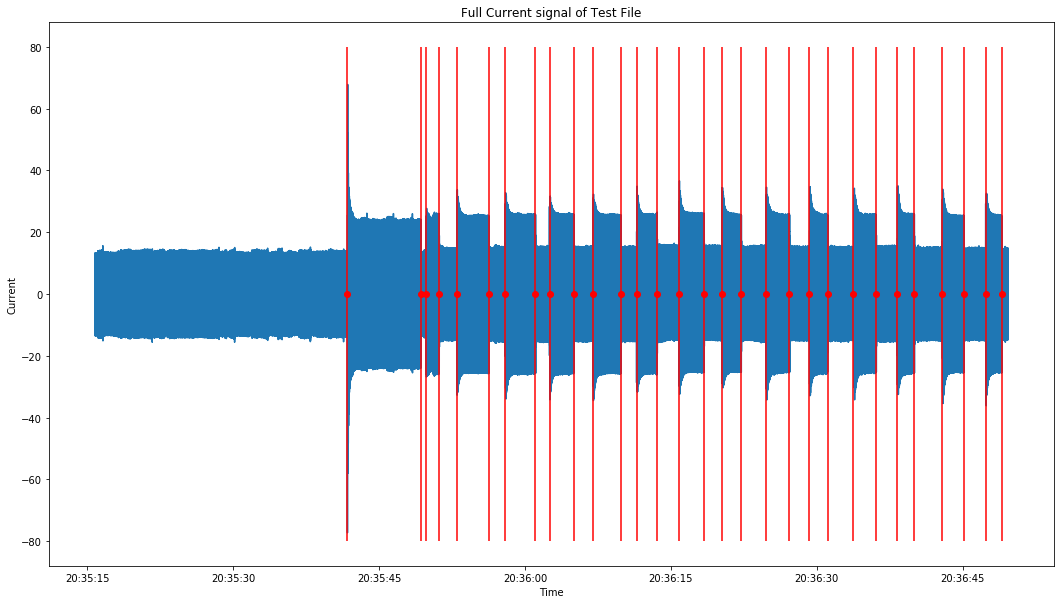

In [7]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data,file_info = load_file_BLUED(test_file)

lable_path:str = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.csv"))[0]
data_start = file_info['file_start']
data_end = file_info['file_end']

labels = load_labels(lable_path, data_start, data_end)

current = data["Current"]
voltage = data["Voltage"]

# Plot the data from the test File
_, ax = plt.subplots(figsize=(18,10))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=labels.index, color='r',ymin=-80, ymax=80, zorder=101)
plt.show()


# Run the Event Detection on the Test Data

In [56]:
found_events=[]
found_events_mean=[]
show_plots = False

samples_remaining = len(current) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window

# Step 1: Initialize  the Event Detector with the Hypperparameter dictionary 
EventDet_Barsim = EventDet_Barsim_Sequential(**init_dict_BLUED) #i.e. values are unpacked into the parameters
EventDet_Barsim.fit() # Call the fit() method to further initialize the algorithm (required by the sklearn API)

while samples_remaining >= samples_raw_per_window_BLUED: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + samples_raw_per_window_BLUED) # compute end index of the new window
    
    # Get the voltage and current windows
    voltage_window = voltage[window_start:window_stop]
    current_window = current[window_start:window_stop]

    # Step 2: Use the feature computation function of the algorithm to compute the input features
    X = EventDet_Barsim.compute_input_signal(voltage=voltage_window, current=current_window, period_length=BLUED_period) 
    
      
    # Step 3: Run the prediciton on the features
    event_interval_indices = EventDet_Barsim.predict(X) #(start_index, end_index) of event if existent is returned
    print(">"+ f"  ({window_start}-{window_stop})")
    if event_interval_indices is not None: # if an event is returned
        
        print("Event Detected at " + str(event_interval_indices)+ f"  ({window_start}-{window_stop})")

        # Plot the computed features
        if show_plots:
            #draw range
            range_line = np.full_like(X, np.NaN)
            range_line[event_interval_indices[0]:event_interval_indices[1]+1] = X[event_interval_indices[0]:event_interval_indices[1]+1]
            
            plt.title("Computed input features for this window"+ f"  ({window_start}-{window_stop})")
            plt.plot(X)
            plt.plot(range_line, color='g', zorder=100, marker='x')
            plt.show()
        
        # Instead of an event interval, we might be interested in an exact event point
        # Hence, we just take the mean of the interval boundaries
        event_time = data.index[int(window_start+EventDet_Barsim._convert_relative_offset(event_interval_indices[0]))]
        found_events.append(str(event_time))
        
        mean_event_index = np.mean([event_interval_indices[0], event_interval_indices[1]])
        mean_event_time = data.index[int(window_start+EventDet_Barsim._convert_relative_offset(mean_event_index))]
        found_events_mean.append(str(mean_event_time))
        
        # We compute a new offset: We start of at the event index
        # The event indices returned are with respect to the feature domain
        # To "stream" the next window, we need it with respect to the raw input data domain
        end_index = EventDet_Barsim._convert_relative_offset(event_interval_indices[1])  # convert it to input domain with utility function
        
        # We need to update the data points that remain for streaming now.
        window_start = int(window_start + end_index) # set new starting point
        
        print("+++++++++++++++++++++++++++++++++++")
        
        # We need to update the data points that remain for streaming now.
        samples_remaining -= end_index
        
    else: #no event was detected
        
        # We start at the end of the previous window
        window_start = int(window_stop)
        
        # Plot the computed features
        if show_plots:
            plt.title("Computed input features for this window"+ f"  ({window_start}-{window_stop})")
            plt.plot(X)
            plt.show()
        
        print("+++++++++++++++++++++++++++++++++++")
    
        # We need to update the data points that remain for streaming now.
        samples_remaining -= samples_raw_per_window_BLUED

C:\Users\rgj\Desktop\nilm\Event_Detectors\Event_Detectors.py:1947: Warning: You have provided less then 5 times of future_window_samples_n than window_size_n samples to the algorithm. Please make sure that your window_size_n is at least big enough for the event detector to work. We recommend using more future samples
  "event detector to work. We recommend using more future samples", Warning)


>  (0-60000)
+++++++++++++++++++++++++++++++++++
>  (60000-120000)
+++++++++++++++++++++++++++++++++++
>  (120000-180000)
+++++++++++++++++++++++++++++++++++
>  (180000-240000)
+++++++++++++++++++++++++++++++++++
>  (240000-300000)
+++++++++++++++++++++++++++++++++++
>  (300000-360000)
+++++++++++++++++++++++++++++++++++
>  (360000-420000)
+++++++++++++++++++++++++++++++++++
>  (420000-480000)
Event Detected at (5, 6)  (420000-480000)
+++++++++++++++++++++++++++++++++++
>  (456000-516000)
+++++++++++++++++++++++++++++++++++
>  (516000-576000)
Event Detected at (5, 5)  (516000-576000)
+++++++++++++++++++++++++++++++++++
>  (546000-606000)
Event Detected at (3, 4)  (546000-606000)
+++++++++++++++++++++++++++++++++++
>  (570000-630000)
Event Detected at (4, 4)  (570000-630000)
+++++++++++++++++++++++++++++++++++
>  (594000-654000)
Event Detected at (4, 5)  (594000-654000)
+++++++++++++++++++++++++++++++++++
>  (624000-684000)
Event Detected at (5, 5)  (624000-684000)
+++++++++++++++++++++

In [57]:
found_events

['2011-10-23 20:35:53.273499',
 '2011-10-23 20:36:01.273499',
 '2011-10-23 20:36:02.773499',
 '2011-10-23 20:36:05.273499',
 '2011-10-23 20:36:07.273499',
 '2011-10-23 20:36:10.273499',
 '2011-10-23 20:36:11.773499',
 '2011-10-23 20:36:13.773499',
 '2011-10-23 20:36:16.273499',
 '2011-10-23 20:36:18.773499',
 '2011-10-23 20:36:20.273499',
 '2011-10-23 20:36:27.273499',
 '2011-10-23 20:36:29.273499',
 '2011-10-23 20:36:31.273499',
 '2011-10-23 20:36:34.273499',
 '2011-10-23 20:36:36.273499',
 '2011-10-23 20:36:38.773499',
 '2011-10-23 20:36:40.273499',
 '2011-10-23 20:36:43.273499',
 '2011-10-23 20:36:45.273499']

In [58]:
labels.index

DatetimeIndex(['2011-10-23 20:35:41.723000', '2011-10-23 20:35:49.290000',
               '2011-10-23 20:35:49.790000', '2011-10-23 20:35:51.174000',
               '2011-10-23 20:35:52.973000', '2011-10-23 20:35:56.257000',
               '2011-10-23 20:35:57.973000', '2011-10-23 20:36:01.073000',
               '2011-10-23 20:36:02.540000', '2011-10-23 20:36:05.007000',
               '2011-10-23 20:36:06.990000', '2011-10-23 20:36:09.857000',
               '2011-10-23 20:36:11.490000', '2011-10-23 20:36:13.590000',
               '2011-10-23 20:36:15.823000', '2011-10-23 20:36:18.424000',
               '2011-10-23 20:36:20.240000', '2011-10-23 20:36:22.257000',
               '2011-10-23 20:36:24.757000', '2011-10-23 20:36:27.207000',
               '2011-10-23 20:36:29.240000', '2011-10-23 20:36:31.124000',
               '2011-10-23 20:36:33.790000', '2011-10-23 20:36:36.124000',
               '2011-10-23 20:36:38.274000', '2011-10-23 20:36:40.040000',
               '2011-10-2

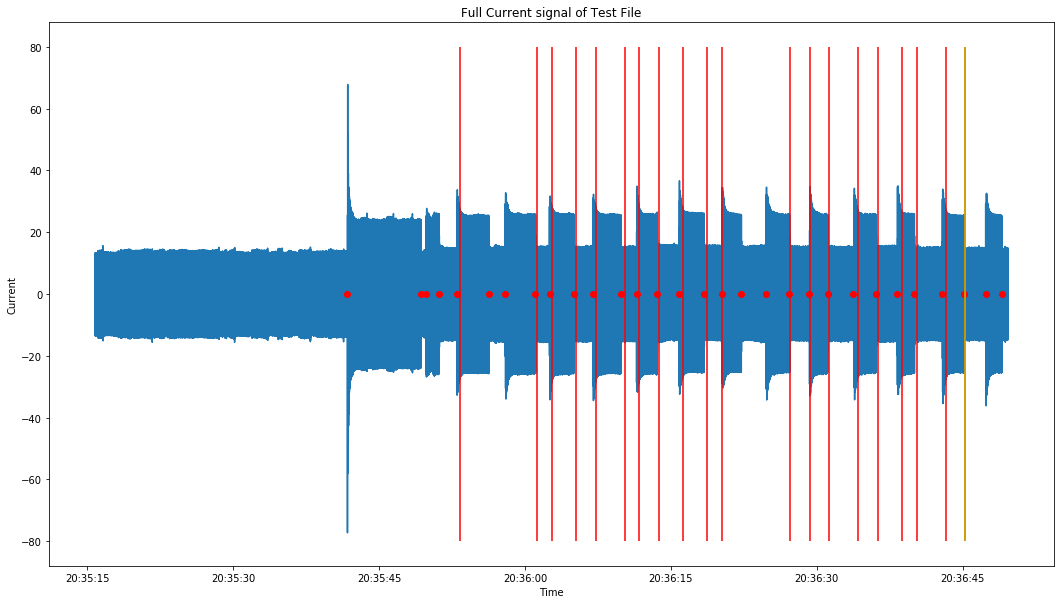

In [59]:
_, ax = plt.subplots(figsize=(18,10))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=found_events, color='red',ymin=-80, ymax=80, zorder=101)

#end of sliding window
ax.vlines(x=data.index[window_start], color='y',ymin=-80, ymax=80, zorder=101)
plt.show()